# 1. Introduction

This notebook explores a fitbit dataset and in the end tries to predict the number of steps walked. 

## Setup


In [277]:
import seaborn as sns #this is the plotting library I'll be using 
import pandas as pd #"as pd" means that we can use the abbreviation in commands
import matplotlib.pyplot as plt #we need Matplotlib for setting the labels in the Seaborn graphs
import math
from sklearn.linear_model import LinearRegression #remember, this is linear regression model from sk-learn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

df1 = pd.read_csv('survey.csv')
df2 = pd.read_csv('steps.csv', sep=';')


# 2. Data Cleaning

### 2.1 inspect data frames

In [278]:
df1.head()


,id,city,gender,age,hh_size,education,education_1,height,weight
0,1,Bordeaux,Male,25-34,4,4,Master or doctorate,178.0,98.0
1,2,Lille,Male,35-44,1,3,Bachelor,180.0,77.0
2,3,Montpellier,Male,25-34,2,2,Master or doctorate,180.0,83.0
3,4,Lyon,Male,<25,1,1,Bachelor,178.0,80.0
4,5,Montpellier,Female,25-34,3,4,Bachelor,167.0,61.0


In [279]:
df2.head()

,id,20-6-2013,21-6-2013,22-6-2013,23-6-2013,24-6-2013,25-6-2013,26-6-2013,27-6-2013,28-6-2013,...,4-5-2014,5-5-2014,6-5-2014,7-5-2014,8-5-2014,9-5-2014,10-5-2014,11-5-2014,12-5-2014,13-5-2014
0,1,NaN,NaN,NaN,NaN,3941.0,15733.0,9929.0,12879.0,10541.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,10473.0,705.0,4287.0,5507.0,4024.0,3926.0,14595.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,11428.0,12523.0,2553.0,190.0,2164.0,8185.0,9630.0,8983.0,...,3914.0,4364.0,NaN,NaN,NaN,6227.0,4567.0,2567.0,1129.0,NaN
3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2.2 Merge dataframes on ID column

In [280]:
df = pd.merge(df1, df2, on = 'id') #id is identifier
df.head()

,id,city,gender,age,hh_size,education,education_1,height,weight,20-6-2013,...,4-5-2014,5-5-2014,6-5-2014,7-5-2014,8-5-2014,9-5-2014,10-5-2014,11-5-2014,12-5-2014,13-5-2014
0,1,Bordeaux,Male,25-34,4,4,Master or doctorate,178.0,98.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Lille,Male,35-44,1,3,Bachelor,180.0,77.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Montpellier,Male,25-34,2,2,Master or doctorate,180.0,83.0,NaN,...,3914.0,4364.0,NaN,NaN,NaN,6227.0,4567.0,2567.0,1129.0,NaN
3,4,Lyon,Male,<25,1,1,Bachelor,178.0,80.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Montpellier,Female,25-34,3,4,Bachelor,167.0,61.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2.3 Remove impossible values from weight and height

In [281]:
df = df.dropna(subset=['weight'])
df = df.dropna(subset=['height'])
df['weight'] = df['weight'].apply(pd.to_numeric, errors='coerce')
df = df[(df['weight'] > 35) & (df['weight'] < 300)] #exclude everybody below 35 and above 300 kg.
df = df[(df['height'] > 100) & (df['height'] < 240)] 

#### 2.4 inspect cleaning
#### inspect weight column by visualizing
- seems okay, pretty normally distributed without outliers

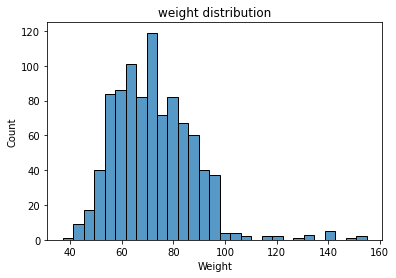

In [282]:
sns.histplot(df['weight'].dropna(), kde=False) #Selecting the rating column. I need to drop the NA's for the plot
plt.title('weight distribution')
plt.xlabel('Weight')
plt.show()

### 2.5 Add variables
#### create mean steps per participant variable for later investigation

In [283]:
step_col = [col for col in df.columns if '2013' in col] #find step columns for 2013 and 2014
step_col_2014 =[col for col in df.columns if '2014' in col]
for i in step_col_2014:
    step_col.append(i)

In [284]:
df['mean_steps'] = df.loc[:, step_col[0]:step_col[-1]].mean(axis=1) #calculate mean of all step columns
cols = df.columns.tolist() # column list
cols.insert(9, cols.pop(cols.index('mean_steps'))) #change index
df = df.reindex(columns= cols) #place mean_steps up front for better readability
df = df.round({'mean_steps': 0}) #round steps
df.head()

,id,city,gender,age,hh_size,education,education_1,height,weight,mean_steps,...,4-5-2014,5-5-2014,6-5-2014,7-5-2014,8-5-2014,9-5-2014,10-5-2014,11-5-2014,12-5-2014,13-5-2014
0,1,Bordeaux,Male,25-34,4,4,Master or doctorate,178.0,98.0,10206.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Lille,Male,35-44,1,3,Bachelor,180.0,77.0,5687.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Montpellier,Male,25-34,2,2,Master or doctorate,180.0,83.0,8302.0,...,3914.0,4364.0,NaN,NaN,NaN,6227.0,4567.0,2567.0,1129.0,NaN
3,4,Lyon,Male,<25,1,1,Bachelor,178.0,80.0,3633.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Montpellier,Female,25-34,3,4,Bachelor,167.0,61.0,5312.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2.6 add BMI feature

In [285]:
df['bmi'] = (df['weight'] / df['height'] / df['height']) * 10000
cols = df.columns.tolist() # column list
cols.insert(10, cols.pop(cols.index('bmi'))) #change index
df = df.reindex(columns= cols) #place bmi up front for better readability
df = df.round({'bmi': 2}) #round bmi
df.head()

,id,city,gender,age,hh_size,education,education_1,height,weight,mean_steps,...,4-5-2014,5-5-2014,6-5-2014,7-5-2014,8-5-2014,9-5-2014,10-5-2014,11-5-2014,12-5-2014,13-5-2014
0,1,Bordeaux,Male,25-34,4,4,Master or doctorate,178.0,98.0,10206.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Lille,Male,35-44,1,3,Bachelor,180.0,77.0,5687.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Montpellier,Male,25-34,2,2,Master or doctorate,180.0,83.0,8302.0,...,3914.0,4364.0,NaN,NaN,NaN,6227.0,4567.0,2567.0,1129.0,NaN
3,4,Lyon,Male,<25,1,1,Bachelor,178.0,80.0,3633.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Montpellier,Female,25-34,3,4,Bachelor,167.0,61.0,5312.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 3. Exploratory Analysis

### 3.1 Distribution mean steps

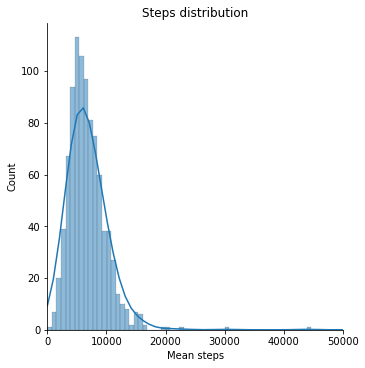

In [286]:
sns.displot(df['mean_steps'].dropna(), kde=True) #Selecting the rating column. I need to drop the NA's for the plot
plt.title('Steps distribution')
plt.xlabel('Mean steps')
plt.xlim(0,50000)
plt.show()

### 3.2 Summary Statistics

In [287]:
df[['mean_steps']].describe()

,mean_steps
count,919.000000
mean,7020.907508
std,7410.708955
min,4.000000
25%,4633.500000
50%,6245.000000
75%,8378.000000
max,201723.000000


#### Interpretation

The data seems to be pretty normally distributed. However there are some extreme values (outliers) on the right side causing a slight skew to the right. The average amount os steaps for somebody to walk is 7020 (when they use the fitbit). The standard deviation seems really high at 7410 indicating that most data is spread over a wide range

### 3.3 Relation of mean steps with age and gender

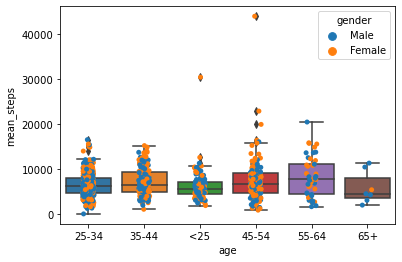

In [288]:
df = df[(df['mean_steps'] < 50000)] #remove outlier
ax = sns.boxplot(x="age", y="mean_steps", data=df)
ax = sns.stripplot(x="age", y="mean_steps", hue="gender", data=df)
plt.show()

#### interpretation

we can see that the 65+ group is relatively small and that their mean number of steps is also a lot lower than the younger groups. The youngest group of 25-34 is however walking less than the group of 35-44. The younger group does have more outliers. All groups show about the same results for gender and are evenly distributed across gender. The group of 55-64 doees have less observations, but they tend to walk the most steps on average. 

### 3.4 Scatterplot and Correlation matrix numerical variables

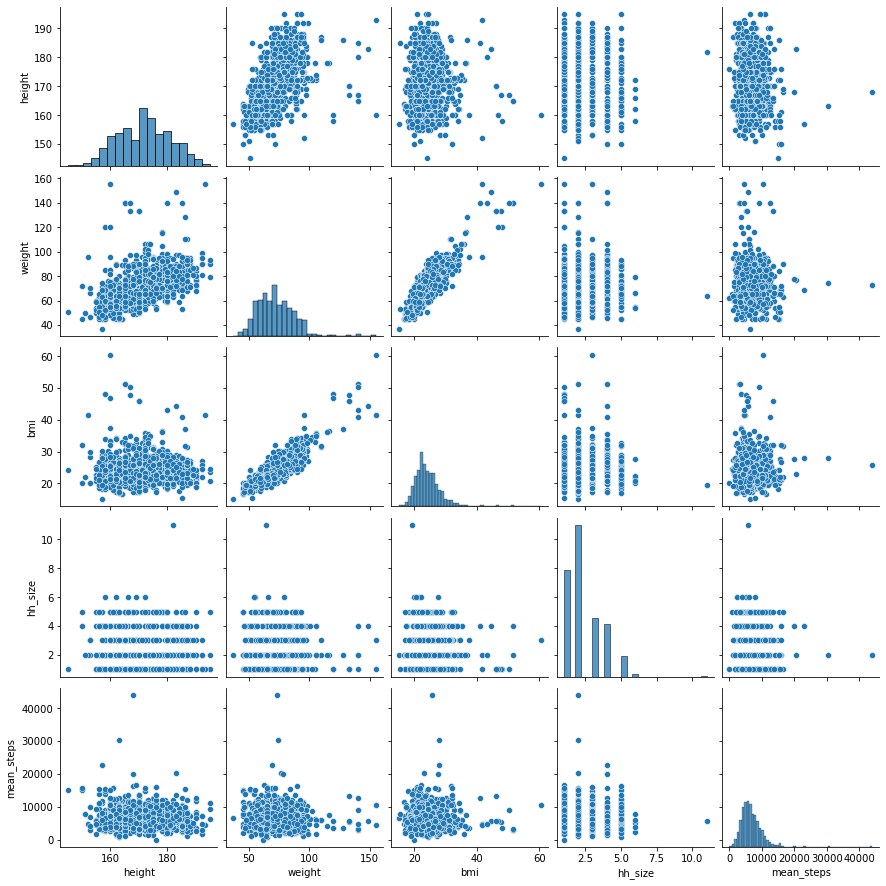

In [289]:
df_numerical = df[['height','weight','bmi','hh_size','mean_steps']]
sns.pairplot(df_numerical)
plt.show() #using Matplotlib to show the plot

The scatterplot shows that height and household size are not correlated as one would expect. Height and weight are positively correlated. Somebody that is tall also likely weighs more. Our BMI feuture on the other hand just indicates 'healthy' weight and thus is not related with height since a tall person can still have a low BMI. However, people that weigh more and are shorter have a higher BMI. This means that BMI is positively correlated with weight since heavier people tend to have a higher bmi (if height is taken into account). Weight doesn't seem to matter for the number of steps walked unless we take the heavy outliers into account. These 'very' heavy people seem to walk less since there are fewer observations there (which can also be observed in the mean_steps/bmi plot). 

Our observations are confirmed in the correlation matrix below where only weight/height and bmi/weight stand out. The other numerical variables don't seem to have a significant correaltion.

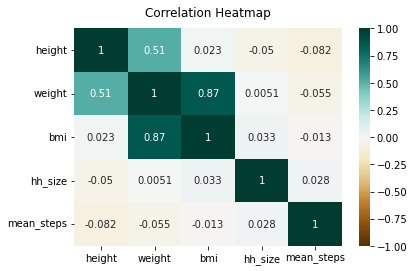

In [290]:
heatmap = sns.heatmap(df_numerical.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);


## 4. Predictive Model using linear regression

linear regression models help you predict a dependent variable using other independent variables on the condition that there is a linear relationship (otherwise transformation is needed).

### 4.1 Model

In [291]:
#education_1 / age / gender are categorical varibles

education_1_dummies = pd.get_dummies(df['education_1'])### create dummies
df = pd.concat([df, education_1_dummies], axis=1) 
df.drop(['No degree'], inplace=True, axis=1)

age_dummies = pd.get_dummies(df['age'])### create dummies
df = pd.concat([df, age_dummies], axis=1) 
df.drop(['<25'], inplace=True, axis=1)

gender_dummies = pd.get_dummies(df['gender'])### create dummies
df = pd.concat([df, gender_dummies], axis=1) 
df.drop(['Male'], inplace=True, axis=1)

df.drop(df.loc[:,'20-6-2013':'13-5-2014'], inplace=True, axis=1) #make dataset more readable


In [292]:
y = df['mean_steps'] #We need to take out the rating as our Y-variable
X = df[['height','weight','bmi','hh_size','Bachelor','High school','Master or doctorate','Primary','Vocational','25-34','35-44','45-54','55-64','65+','Female']]
#X = df.loc[:,'rooms':'apartment'] 
X.index = df['id'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) #split the data, store it into different variables

lm = LinearRegression() #create the model
model = lm.fit(X_train, y_train) #train the model
y_test_p = lm.predict(X_test) #Generate predictions for the test data. So we use X.test, not X.train
X_train.head() #The train data

,height,weight,bmi,hh_size,Bachelor,High school,Master or doctorate,Primary,Vocational,25-34,35-44,45-54,55-64,65+,Female
id,,,,,,,,,,,,,,,
553,178.0,77.0,24.30,4,0,0,1,0,0,0,0,0,1,0,0
683,172.0,95.0,32.11,1,0,1,0,0,0,1,0,0,0,0,1
249,170.0,64.0,22.15,1,0,0,1,0,0,0,1,0,0,0,1
261,175.0,73.0,23.84,2,1,0,0,0,0,0,0,0,1,0,1
165,181.0,80.0,24.42,4,1,0,0,0,0,0,0,1,0,0,0


/Users/niels/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


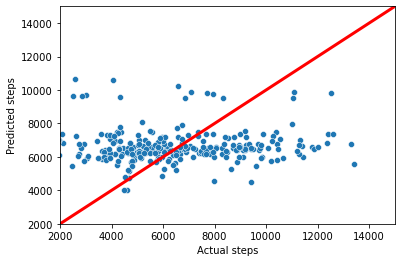

In [293]:
sns.scatterplot(y_test, y_test_p)
plt.xlabel('Actual steps')
plt.ylabel('Predicted steps')
plt.xlim([2000,15000]) #Forcing the x- and y-axis to be the same length, so that we can compare 
plt.ylim([2000,15000])
plt.plot([2000, 15000], [2000, 15000], color='red', lw=3) #Plot a diagonal length
plt.show()

We notice that our predictions are not very good since the actual steps are not on near the predicted line. It indicates that the independent variables seem to have little effect/relation with the number of steps. 

### 4.2 Evaluation

In [294]:
coef = pd.DataFrame(X.columns.values, lm.coef_) #this creates a df with a column with the column names, and the coefficients of the model
coef

,0
67.346161,height
-105.804278,weight
254.305876,bmi
-45.468379,hh_size
359.914781,Bachelor
1055.477217,High school
305.129883,Master or doctorate
-270.010605,Primary
-1450.511276,Vocational
505.712874,25-34


The coefficients of our model. Height seems to have a positive relation with the predicted steps. Weight a negative (makes sense, since heavy people likely walk less). However, BMI has a positive effect which doesn't make sense based on the previous assumption. The group of 35-44 year olds seems to walk a lot more than the reference category of <35 while high school students also walk more than people without an education. Femals tend to also walk less in our training dataset. These coefficients say nothing about significance, which is likely very low. 

In [295]:
r2_score(y_test, y_test_p) # r squared

-0.056006390336731826

The very low r2 score indeed suggests that our model is not able to predict the mean number of steps

In [296]:
math.sqrt(mean_squared_error(y_test, y_test_p))

4214.971907969458

In [297]:
df['mean_steps'].describe()

count      917.000000
mean      6752.453653
std       3269.402999
min          4.000000
25%       4633.000000
50%       6240.000000
75%       8335.000000
max      43912.000000
Name: mean_steps, dtype: float64

Again confirms our beliefs. The RMSE is very high since the mean number of steps is 6752 so being off by 4214 seems hight. 

### residuals

In [298]:
#residuals = y_test - y_test_p
#X_test = pd.concat([X_test, residuals], axis=1) 
#sns.scatterplot(x='mean_steps',y='residuals',data=X_test)
#plt.xlabel('index')
#plt.ylabel('Residuals steps')
#plt.show()

#could not get this to work. The predicted number of steps series seems to have an error, because it has les observatinos than the X_test dataframe after concatting due to indexing problems i guess

## 5. Conclusion

Based on our analysis we can say that our model is not very good at predicting the number of steps a person walked. Liekly due to the fact that there are a lot of extraveneous factors at play. 

In [299]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

In [300]:
y_test = y_test.values.reshape(-1,1) #reshape to a numpy array because it would otherwise not work. 

In [305]:
model = sm.OLS(y_test, X_test[['height','weight','bmi','hh_size','Bachelor','High school','Master or doctorate','Primary','Vocational','25-34','35-44','45-54','55-64','65+','Female']])
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.760
Model:                            OLS   Adj. R-squared (uncentered):              0.746
Method:                 Least Squares   F-statistic:                              55.17
Date:                Tue, 07 Dec 2021   Prob (F-statistic):                    7.18e-72
Time:                        14:48:31   Log-Likelihood:                         -2676.9
No. Observations:                 276   AIC:                                      5384.
Df Residuals:                     261   BIC:                                      5438.
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

Trying a more classical approach using OLS. The R squared is much higher, because we are using the test dataset to predict the test outcome. However, the coefficients show that no variables have a significant effect. 